In [1]:
from numpy import array
import numpy as np
import keras
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
import pandas as pd

from math import log
from math import exp
from scipy.stats import boxcox



In [2]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [3]:
def invert_boxcox(value, lam):
	# log case
	if lam == 0:
		return exp(value)
	# all other cases
	return exp(log(lam * value + 1) / lam)

In [18]:

data = pd.read_excel('New data.xlsx')
provinces = data.columns[1:]    
print(provinces)
t = data.iloc[0:192] #11565
v = data.iloc[180:228]
ts = data.iloc[228:252]
print(t)
# pl=data.iloc[0:252]
# define input sequence
for province in provinces:
    train_seq = t[province].values
    val_seq = v[province].values
    test_seq = ts[province].values
    # train_seq = t.loc[:, province].values
    # val_seq = v.loc[:, province].values
    # test_seq = ts.loc[:, province].values

    # plot_seq = pl['Bãi Cháy'].values
    # print(test_seq)
    tr, tr_lamb = boxcox(train_seq)
    vl, vl_lamb = boxcox(val_seq)
    ts, ts_lamb = boxcox(test_seq)

print('Training Sequence : %d'%len(train_seq))
print('Validation Sequence : %d'%len(val_seq))
print('Testing Sequence : %d'%len(test_seq))

Index(['Bãi Cháy', 'Cà Mau', 'Đà Lạt', 'Đà Nẵng', 'Hà Nội', 'Huế', 'Lai Châu',
       'Nam Định', 'Nha Trang', 'Pleiku', 'Quy Nhơn', 'Sơn La', 'Tuyên Quang',
       'Vinh', 'Vũng Tàu'],
      dtype='object')
     Unnamed: 0  Bãi Cháy  Cà Mau  Đà Lạt  Đà Nẵng  Hà Nội     Huế  Lai Châu  \
0             0       5.0    4.00   10.74     33.0     9.0    73.0      73.0   
1             1      21.0   28.41   14.00     64.0    24.0    31.0      53.0   
2             2      12.0    1.00  120.00      4.0    11.0    22.0      78.0   
3             3      17.0    4.00  102.00    113.0    59.0    56.0     114.0   
4             4     413.0  274.00  123.00     39.0   214.0   242.0     341.0   
..          ...       ...     ...     ...      ...     ...     ...       ...   
187         187     646.0  383.10  294.60    178.7   283.2   133.9     566.8   
188         188     264.1  291.50  270.90    198.0   266.9   216.5     284.6   
189         189     384.4  453.80  272.70    363.5   259.7   384.5     1

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [5]:
n_steps_in, n_steps_out = 12, 12
# split into samples
X_train, y_train = split_sequence(tr, n_steps_in, n_steps_out)
X_val, y_val = split_sequence(vl, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(ts, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)


X_train shape: (169, 12, 1)
X_val shape: (25, 12, 1)
X_test shape: (1, 12, 1)


In [6]:
import keras.backend as kb

def r2_score(y_true, y_pred):
    ss_res = kb.sum(kb.square(y_true - y_pred))
    ss_tot = kb.sum(kb.square(y_true - kb.mean(y_true)))
    return (1 - ss_res/(ss_tot + kb.epsilon()))

model = Sequential()
model.add(Conv1D(filters=126, kernel_size=2, activation='tanh', input_shape=(n_steps_in, n_features), kernel_regularizer=keras.regularizers.l2(l=0.01), kernel_initializer='he_normal'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(n_steps_out))

adam = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=adam, loss='mse', metrics=[r2_score, 'mae', keras.metrics.RootMeanSquaredError()])

In [7]:
history = model.fit(X_train, y_train, epochs=200, verbose=1, validation_data=(X_val, y_val), batch_size=64)


Epoch 1/200
3/3 [==============================] - 1s 126ms/step - loss: 64.3480 - r2_score: -3.8001 - mae: 6.9763 - root_mean_squared_error: 7.8549 - val_loss: 31.0723 - val_r2_score: -3.3752 - val_mae: 4.7765 - val_root_mean_squared_error: 5.3320
Epoch 2/200
3/3 [==============================] - 0s 19ms/step - loss: 43.6460 - r2_score: -2.1888 - mae: 5.4802 - root_mean_squared_error: 6.4036 - val_loss: 18.1664 - val_r2_score: -1.3904 - val_mae: 3.2617 - val_root_mean_squared_error: 3.9412
Epoch 3/200
3/3 [==============================] - 0s 17ms/step - loss: 29.1954 - r2_score: -1.0623 - mae: 4.2670 - root_mean_squared_error: 5.1540 - val_loss: 11.1995 - val_r2_score: -0.3195 - val_mae: 2.2408 - val_root_mean_squared_error: 2.9281
Epoch 4/200
3/3 [==============================] - 0s 19ms/step - loss: 20.5455 - r2_score: -0.3967 - mae: 3.4740 - root_mean_squared_error: 4.2335 - val_loss: 9.2042 - val_r2_score: -0.0137 - val_mae: 2.0917 - val_root_mean_squared_error: 2.5665
Epoch 5/

In [8]:
# y_pred = model.predict(X_test)
# print(y_pred)
# print(X_test)
last_epoch_metrics = {
    'loss': history.history['loss'][-1],
    'r2_score': history.history['r2_score'][-1],
    'mae': history.history['mae'][-1],
    'rmse': history.history['root_mean_squared_error'][-1]
}
print(last_epoch_metrics)

{'loss': 5.714311599731445, 'r2_score': 0.6468262672424316, 'mae': 1.6652874946594238, 'rmse': 2.113990545272827}


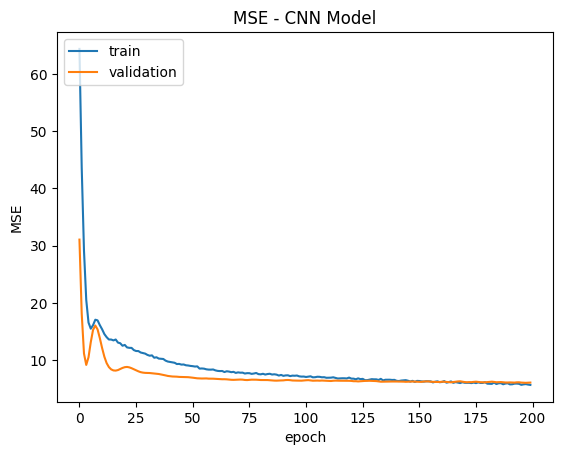

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MSE - CNN Model')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.savefig('saved/cnn/loss.png')
plt.show()

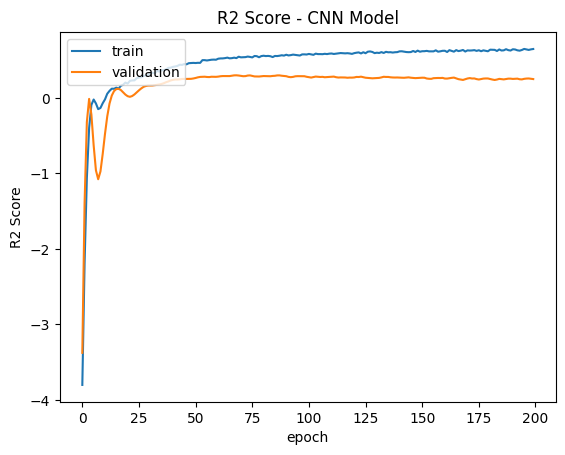

In [10]:
plt.plot(history.history['r2_score'])
plt.plot(history.history['val_r2_score'])
plt.title('R2 Score - CNN Model')
plt.ylabel('R2 Score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.savefig('saved/cnn/r2_score.png')
plt.show()

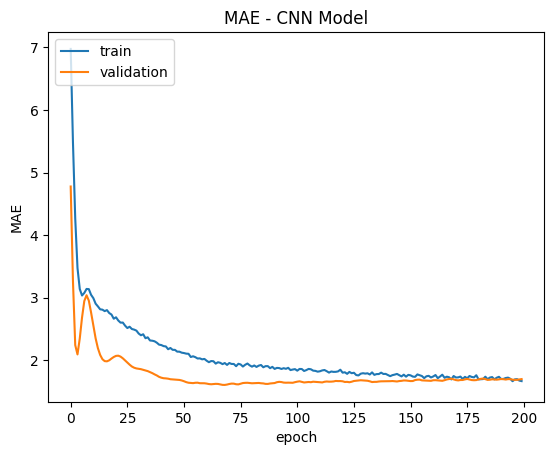

In [11]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE - CNN Model')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.savefig('saved/cnn/mae.png')
plt.show()

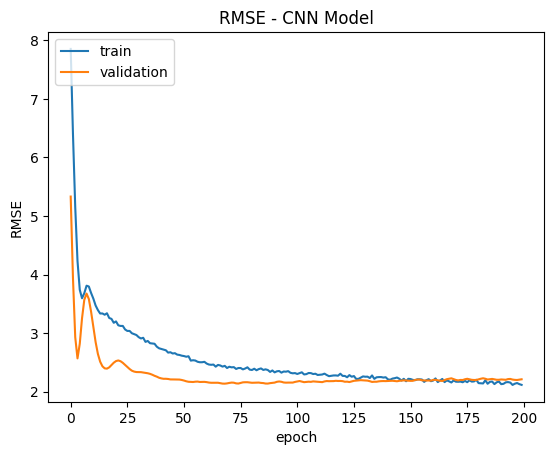

In [12]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('RMSE - CNN Model')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.savefig('saved/cnn/rmse.png')
plt.show()